In [ ]:
!pip install pytorch_forecasting
!git clone https://github.com/ChanCheeKean/datasets.git
!mkdir data
!mv datasets/deepAR/* ./data

In [ ]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, Sampler
from pytorch_forecasting import Baseline, DeepAR, NBeats, TimeSeriesDataSet
from pytorch_forecasting.metrics import SMAPE, MultivariateNormalDistributionLoss
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
import pytorch_lightning as pl

# 1) DeepAR

* Classic time series models usually learn from past observations and therefore predict future values using solely recent history. These models include Autoregression (AR), Moving Average (MA), Autoregressive Integrated Moving Average (ARIMA), and Simple Exponential Smoothing (SES).
* The parameters are estimated independently for each time series without taking advantage of the potential positive effects of cross-learning.
* In an attempt to account for some determinant factors, such as autocorrelation structure, trends, seasonality, and other explanatory variables, approaches consist of selecting the best model for each time series or group of time series and require us to define heuristics, manual interventions, and fine-tuning steps.

Released by Amazon and integrated into its ML platform SageMaker, DeepAR stands out for its ability to learn at “scale” using multiple covariates. It consists of a forecasting methodology based on AR RNNs that learn a global model from historical data of all time series in the dataset and produces accurate probabilistic forecasts.

* **Probabilistic forecasting**. DeepAR does not estimate the time series’ future values but their future probability distribution. This allows practitioners to compute quantile estimates and thus improves the optimization of business processes. For instance, it enables retailers to better estimate their inventory and brokers to better assess the risk exposure of their portfolio.

* **Covariates**. DeepAR is able to capture complex and group-dependent relationships by using covariates. It alleviates the efforts and time needed to select and prepare covariates and model section heuristics typically used with classical forecast models.

* **Cold-start issues**. While traditional methods that predict only one time series at a time fail to provide predictions for items that have little or no history available, DeepAR is able to use learning from similar items to achieve this.

* **Cross-Relationship** The demand for one product (e.g. hotdogs) would affect the demand for its substitute(s) (e.g. hamburgers).


https://blog.dataiku.com/deep-learning-time-series-forecasting

## 1.1 Pytorch-Forecasting

https://medium.com/@corymaklin/deepar-forecasting-algorithm-6555efa63444

In [ ]:
train_df = pd.read_csv("https://raw.githubusercontent.com/tcdat96/product-demand-forecast/master/dataset/train.csv")
test_df = pd.read_csv("https://raw.githubusercontent.com/tcdat96/product-demand-forecast/master/dataset/test.csv")

train_df['date'] = pd.to_datetime(train_df['date'], errors='coerce')
train_df[['store', 'item']] = train_df[['store', 'item']].astype(str)
train_df['sales'] = pd.to_numeric(train_df['sales'], downcast='float')
min_date = train_df['date'].min()
train_df["time_idx"] = train_df["date"].map(lambda current_date: (current_date - min_date).days)

# total 500 time series groupby store and item
train_df.head()

,date,store,item,sales,time_idx
0,2013-01-01,1,1,13.0,0
1,2013-01-02,1,1,11.0,1
2,2013-01-03,1,1,14.0,2
3,2013-01-04,1,1,13.0,3
4,2013-01-05,1,1,10.0,4


In [ ]:
# use the data from the past 60 days in order to make a prediction about the next 20 days
max_encoder_length = 60
max_prediction_length = 20
training_cutoff = train_df["time_idx"].max() - max_prediction_length

# create time series dataset
training = TimeSeriesDataSet(
    train_df[train_df['time_idx'] <= training_cutoff],
    time_idx="time_idx",
    target="sales",
    group_ids=["store", "item"], # list of column names identifying a time series.
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["store", "item"], # static categorical variables
    time_varying_unknown_reals=["sales"],
)

# validation set
validation = TimeSeriesDataSet.from_dataset(training, train_df, min_prediction_idx=training_cutoff + 1)

# dataloader
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [ ]:
sample_loader = next(iter(train_dataloader))
print('Target Size: ', sample_loader[1][0].size())

for key in sample_loader[0].keys():
    print(f"{key} Size", sample_loader[0][key].size())

Target Size:  torch.Size([128, 20])
encoder_cat Size torch.Size([128, 60, 2])
encoder_cont Size torch.Size([128, 60, 1])
encoder_target Size torch.Size([128, 60])
encoder_lengths Size torch.Size([128])
decoder_cat Size torch.Size([128, 20, 2])
decoder_cont Size torch.Size([128, 20, 1])
decoder_target Size torch.Size([128, 20])
decoder_lengths Size torch.Size([128])
decoder_time_idx Size torch.Size([128, 20])
groups Size torch.Size([128, 2])
target_scale Size torch.Size([128, 2])


In [ ]:
# define trainer and model
# check https://pytorch-forecasting.readthedocs.io/en/stable/api/pytorch_forecasting.models.deepar.DeepAR.html
net = DeepAR.from_dataset(
    training,
    learning_rate=0.7,
    log_interval=10,
    log_val_interval=1,
    hidden_size=30,
    rnn_layers=2,
    loss=MultivariateNormalDistributionLoss(rank=30),
    cell_type='LSTM'
)

# get suggested learning rate
# trainer = pl.Trainer(gpus=[0], gradient_clip_val=0.1, default_root_dir='./temp')
# res = trainer.tuner.lr_find(
#     net,
#     train_dataloaders=train_dataloader,
#     val_dataloaders=val_dataloader,
#     min_lr=1e-5,
#     max_lr=1,
#     early_stop_threshold=100,
# )
# fig = res.plot(show=True, suggest=True)
# fig.show()

early_stop_callback = EarlyStopping(
    monitor="val_loss", 
    min_delta=1e-4, 
    patience=10, 
    verbose=False, 
    mode="min"
)

trainer = pl.Trainer(
    max_epochs=30,
    gpus=[0],
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    limit_train_batches=50,
    enable_checkpointing=True,
    default_root_dir='./temp'
)

# model fitting
trainer.fit(net, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
best_model = DeepAR.load_from_checkpoint(best_model_path)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_ligh

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

temp/lightning_logs/version_1/checkpoints/epoch=10-step=550.ckpt


/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


Prediction Outut Size:  torch.Size([500, 20, 50])


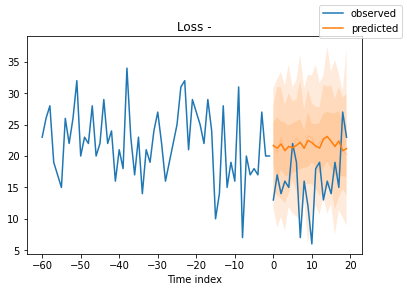

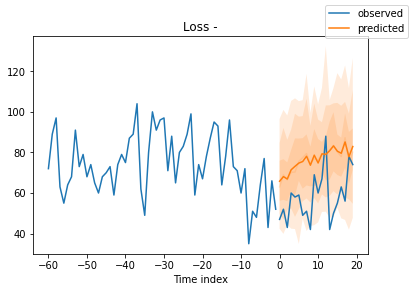

In [ ]:
# Predict raw (unnormalized) values, return x = time step
# mode = raw to return [500, 20]
raw_predictions, x = best_model.predict(val_dataloader, mode="raw", return_x=True, n_samples=50)
print("Prediction Outut Size: ", raw_predictions.prediction.size())

for idx in range(2):
    # print(raw_predictions.prediction[idx].mean(axis=1))
    best_model.plot_prediction(
        x,
        raw_predictions,
        idx=idx,
        add_loss_to_title=SMAPE()
    )

## 1.2 Building DeepAR from scratch

In [ ]:
### DataLoader
class TestDataset(Dataset):
    def __init__(self, data_path):
        self.data = np.load(os.path.join(data_path, f'test_data_elect.npy'))
        self.v = np.load(os.path.join(data_path, f'test_v_elect.npy'))
        self.label = np.load(os.path.join(data_path, f'test_label_elect.npy'))
        self.test_len = self.data.shape[0]

    def __len__(self):
        return self.test_len

    def __getitem__(self, index):
        return (
            self.data[index,:,:-1],
            int(self.data[index,0,-1]),
            self.v[index],
            self.label[index]
        )

test_set = TestDataset("./data")
test_loader = DataLoader(
    test_set, 
    batch_size=256, 
    num_workers=4
)

train_batch, idx, v, labels_batch = next(iter(test_loader))
print(train_batch.shape)    
print(idx.shape)
print(v.shape)
print(labels_batch.shape)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([256, 192, 5])
torch.Size([256])
torch.Size([256, 2])
torch.Size([256, 192])


In [ ]:
### model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
    
        self.num_class = 370 # 370 household
        self.embedding_dim = 20
        self.cov_dim = 4
        self.lstm_hidden_dim = 40
        self.lstm_layers = 3
        self.lstm_dropout = 0.1
        
        # take away embedding if not continuous
        self.embedding = nn.Embedding(self.num_class, self.embedding_dim)
        self.lstm = nn.LSTM(
            input_size=1 + self.cov_dim + self.embedding_dim, 
            hidden_size=self.lstm_hidden_dim,
            num_layers=self.lstm_layers,
            bias=True,
            batch_first=False,
            dropout=self.lstm_dropout
            )
        
        # initialization
        # initialize LSTM forget gate bias to be 1 as recommanded
        for names in self.lstm._all_weights:
            for name in filter(lambda n: "bias" in n, names):
                bias = getattr(self.lstm, name)
                n = bias.size(0)
                start, end = n // 4, n // 2
                bias.data[start:end].fill_(1.)

        self.relu = nn.ReLU()
        self.distribution_mu = nn.Linear(self.lstm_hidden_dim * self.lstm_layers, 1)
        self.distribution_presigma = nn.Linear(self.lstm_hidden_dim * self.lstm_layers, 1)
        self.distribution_sigma = nn.Softplus()

    def init_hidden(self, input_size):
        return torch.zeros(
            self.lstm_layers, 
            input_size, 
            self.lstm_hidden_dim
            )

    def init_cell(self, input_size):
        return torch.zeros(
            self.lstm_layers, 
            input_size, 
            self.lstm_hidden_dim
            )

    def forward(self, x, idx, hidden, cell):
        '''
        Predict mu and sigma of the distribution for z_t.
        Args:
            x: ([1, batch_size, 1+cov_dim]): z_{t-1} + x_t, note that z_0 = 0
            idx ([1, batch_size]): one integer denoting the time series id
            hidden ([lstm_layers, batch_size, lstm_hidden_dim]): LSTM h from time step t-1
            cell ([lstm_layers, batch_size, lstm_hidden_dim]): LSTM c from time step t-1
        Returns:
            mu ([batch_size]): estimated mean of z_t
            sigma ([batch_size]): estimated standard deviation of z_t
            hidden ([lstm_layers, batch_size, lstm_hidden_dim]): LSTM h from time step t
            cell ([lstm_layers, batch_size, lstm_hidden_dim]): LSTM c from time step t
        '''     

        # embed id number from (1, m) --> (1, m, 20)
        onehot_embed = self.embedding(idx) # ()

        # (1, m, n_feat) + (1, m, 20) --> (1, m, 25)
        lstm_input = torch.cat((x, onehot_embed), dim=2)

        # (1, m, 25), (3, m, 40) --> (1, m, 25), (3, m, 40)
        output, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))

        # use h from all three layers to calculate mu and sigma
        # (m, 40, 3) --> (m, 120)
        hidden_permute = hidden.permute(1, 2, 0).contiguous().view(hidden.shape[1], -1)

        # (m, 1)
        pre_sigma = self.distribution_presigma(hidden_permute)
        mu = self.distribution_mu(hidden_permute)

        # softplus to make sure standard deviation is positive
        sigma = self.distribution_sigma(pre_sigma)  

        # (m), (m), [3, m, 40], [3, m, 40]
        return torch.squeeze(mu), torch.squeeze(sigma), hidden, cell

def loss_fn(mu, sigma, labels):
    '''
    Compute using gaussian the log-likehood which needs to be maximized. 
    Ignore time steps where labels are missing.
    Args:
        mu: (Variable) dimension [batch_size] - estimated mean at time step t
        sigma: (Variable) dimension [batch_size] - estimated standard deviation at time step t
        labels: (Variable) dimension [batch_size] z_t
    Returns:
        loss: (Variable) average log-likelihood loss across the batch
    '''
    zero_index = (labels != 0)

    # Normal(size = m)
    distribution = torch.distributions.normal.Normal(mu[zero_index], sigma[zero_index])

    # if value is too far away from mean then likelihood will be bigger
    # e.g. mean=0, sigma=1, distribution.log_prob(torch.Tensor([0.01, 10])) --> [-0.9190, -50.9189]
    likelihood = distribution.log_prob(labels[zero_index]) # (m)
    return -torch.mean(likelihood) # float

### testing
train_window = 192
model = Net()
train_batch, idx, v, labels_batch = next(iter(test_loader))
batch_size = train_batch.shape[0]
train_batch = train_batch.permute(1, 0, 2).to(torch.float32) # (in_seq, m, n_feat)
labels_batch = labels_batch.permute(1, 0).to(torch.float32) # (out_seq, m)
idx = idx.unsqueeze(0) # (1, m)

### initialize with zero
hidden = model.init_hidden(batch_size) # (lstm_layers, m, lstm_hidden_dim)
cell = model.init_cell(batch_size) # (lstm_layers, m, lstm_hidden_dim)
loss = torch.zeros(1)

### loss function
mu = []
for t in range(train_window):
    zero_index = (train_batch[t, :, 0] == 0) # (m)
    print('Zero Index size:', zero_index.size())

    # if z_t is missing, replace it by output mu from the last time step
    if t > 0 and torch.sum(zero_index) > 0:
        train_batch[t, zero_index, 0] = mu[zero_index]

    mu, sigma, hidden, cell = model(train_batch[t].unsqueeze_(0).clone(), idx, hidden, cell)
    loss += loss_fn(mu, sigma, labels_batch[t])
    break

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Zero Index size: torch.Size([256])
tensor(-128368.8281, grad_fn=<MeanBackward0>)


# 2) N-beats

https://www.kaggle.com/code/mpware/n-beats-basics/notebook

## 2.1 Pytorch Forecasting

In [ ]:
data = generate_ar_data(seasonality=10.0, timesteps=400, n_series=100, seed=42)
data["static"] = 2
data["date"] = pd.Timestamp("2020-01-01") + pd.to_timedelta(data.time_idx, "D")
data.head()

,series,time_idx,value,static,date
0,0,0,-0.000000,2,2020-01-01
1,0,1,-0.046501,2,2020-01-02
2,0,2,-0.097796,2,2020-01-03
3,0,3,-0.144397,2,2020-01-04
4,0,4,-0.177954,2,2020-01-05


In [ ]:
# create dataset and dataloaders
max_encoder_length = 60
max_prediction_length = 20

training_cutoff = data["time_idx"].max() - max_prediction_length
context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    data[data['time_idx'] <= training_cutoff],
    time_idx="time_idx",
    target="value",
    categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["series"],
    time_varying_unknown_reals=["value"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)

validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [ ]:
# calculate baseline absolute error
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
SMAPE()(baseline_predictions, actuals)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


tensor(0.5462)

In [ ]:
### extract optimial lr
# trainer = pl.Trainer(gpus=0, gradient_clip_val=0.01)
# net = NBeats.from_dataset(
#     training, 
#     learning_rate=3e-2, 
#     weight_decay=1e-2, 
#     widths=[32, 512], 
#     backcast_loss_ratio=0.1
#     )

# res = trainer.tuner.lr_find(
#     net, 
#     train_dataloaders=train_dataloader, 
#     val_dataloaders=val_dataloader, 
#     min_lr=1e-5
# )

# print(f"suggested learning rate: {res.suggestion()}")
# fig = res.plot(show=True, suggest=True)
# fig.show()
# net.hparams.learning_rate = res.suggestion()

In [ ]:
early_stop_callback = EarlyStopping(
    monitor="val_loss", 
    min_delta=1e-4, 
    patience=10, 
    verbose=False, 
    mode="min"
)

trainer = pl.Trainer(
    max_epochs=100,
    gpus=0,
    enable_model_summary=True,
    gradient_clip_val=0.01,
    callbacks=[early_stop_callback],
    limit_train_batches=30,
)

net = NBeats.from_dataset(
    training,
    learning_rate=4e-3,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    widths=[32, 512],
    backcast_loss_ratio=1.0,
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:441: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_forecasting/models/nbeats/sub_modules.py:154: UserWarning: Creating a tensor from a list of numpy.ndarrays

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/trainer.py:1595: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [ ]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(0.1829)

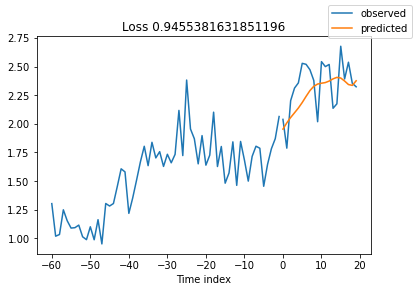

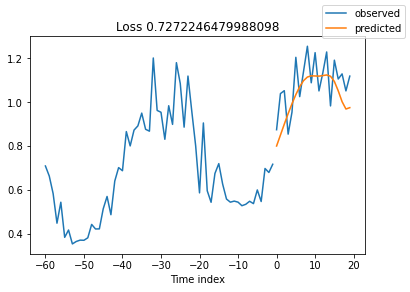

In [ ]:
raw_predictions, x = best_model.predict(val_dataloader, mode="raw", return_x=True)

# plot N examples
for idx in range(2):
    best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True)

## 2.2 Building N-BEATS from Scratch

explaination: https://kshavg.medium.com/n-beats-neural-basis-expansion-analysis-for-interpretable-time-series-forecasting-91e94c830393

kaggle: https://www.kaggle.com/code/mpware/n-beats-basics/notebook

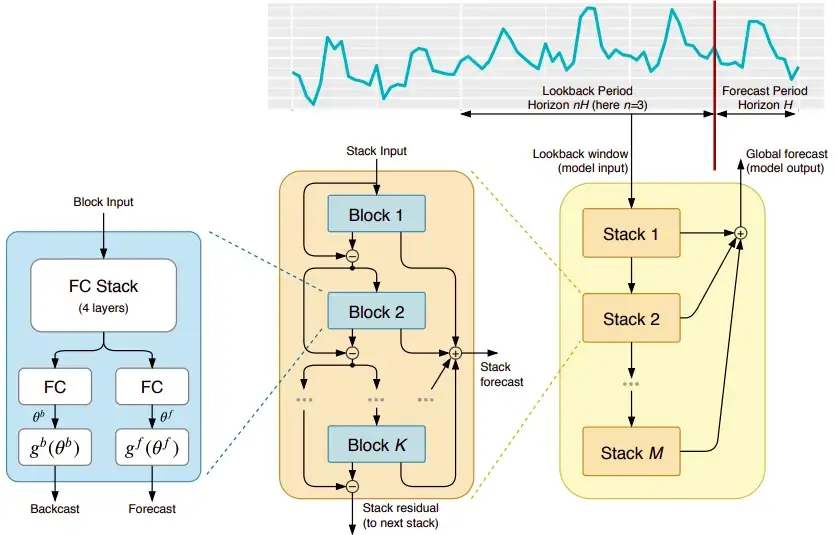


In [ ]:
### prepare data
data = generate_ar_data(seasonality=10.0, timesteps=400, n_series=100, seed=42)
data["static"] = 2
data["date"] = pd.Timestamp("2020-01-01") + pd.to_timedelta(data.time_idx, "D")

# create dataset and dataloaders
max_encoder_length = 60
max_prediction_length = 20

training_cutoff = data["time_idx"].max() - max_prediction_length
context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    data[data['time_idx'] <= training_cutoff],
    time_idx="time_idx",
    target="value",
    categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["series"],
    time_varying_unknown_reals=["value"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)

validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)
train_batch, label_batch = next(iter(val_dataloader))
print(train_batch['decoder_target'].size(), train_batch['encoder_target'].size())

torch.Size([100, 20]) torch.Size([100, 60])


* **Trend Block**: Remove the last layer of the Basic Block and multiply outputs X and Y with two matrices

* **Seasonality Block**: Remove the last layer of Basic Block and multiply outputs X and Y with two matrices (cos & sin)

In [ ]:
def linspace(backcast_length, forecast_length):
    '''
    e.g. linspace(5, 10)
    return [-5, ..., 10], length=15 
    '''
    lin_space = np.linspace(-backcast_length, forecast_length, backcast_length + forecast_length)
    b_ls = lin_space[:backcast_length]
    f_ls = lin_space[backcast_length:]
    return b_ls, f_ls

class Block(nn.Module):
    '''
    Super class for all the block
    '''

    def __init__(
        self, 
        units, # hidden_layer_units
        thetas_dim, # thetas_dim
        device='cuda',
        backcast_length=60, 
        forecast_length=20, 
        share_thetas=False,
        nb_harmonics=None
        ):

        super(Block, self).__init__()
        self.units = units
        self.thetas_dim = thetas_dim
        self.backcast_length = backcast_length
        self.forecast_length = forecast_length
        self.share_thetas = share_thetas
        self.fc1 = nn.Linear(backcast_length, units)
        self.fc2 = nn.Linear(units, units)
        self.fc3 = nn.Linear(units, units)
        self.fc4 = nn.Linear(units, units)
        self.device = device
        self.backcast_linspace, self.forecast_linspace = linspace(backcast_length, forecast_length)

        if share_thetas:
            self.theta_f_fc = self.theta_b_fc = nn.Linear(units, thetas_dim, bias=False)
        else:
            self.theta_b_fc = nn.Linear(units, thetas_dim, bias=False)
            self.theta_f_fc = nn.Linear(units, thetas_dim, bias=False)

    def forward(self, x):
        x = F.relu(self.fc1(x.to(self.device)))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return x

    def __str__(self):
        block_type = type(self).__name__
        return f'{block_type}(units={self.units}, thetas_dim={self.thetas_dim}, ' \
               f'backcast_length={self.backcast_length}, forecast_length={self.forecast_length}, ' \
               f'share_thetas={self.share_thetas}) at @{id(self)}'


### block for seasonality
def seasonality_model(thetas, t, device):

    # theta(m, forecast_length)
    p = thetas.size()[-1]

    # forecast length divided by 2
    p1, p2 = (p // 2, p // 2) if p % 2 == 0 else (p // 2, p // 2 + 1)

    s1 = torch.tensor([np.cos(2 * np.pi * i * t) for i in range(p1)]).float()
    s2 = torch.tensor([np.sin(2 * np.pi * i * t) for i in range(p2)]).float()
    S = torch.cat([s1, s2])
    return thetas.mm(S.to(device))

class SeasonalityBlock(Block):
    def __init__(
        self, 
        units, 
        thetas_dim, 
        device, 
        backcast_length=60, 
        forecast_length=20, 
        nb_harmonics=None
        ):

        if nb_harmonics:
            super(SeasonalityBlock, self).__init__(
                units, nb_harmonics, device, backcast_length, forecast_length, share_thetas=True)
        else:
            super(SeasonalityBlock, self).__init__(
                units, forecast_length, device, backcast_length, forecast_length, share_thetas=True)

    def forward(self, x):
        # x.size() = (m, hidden_size)
        x = super(SeasonalityBlock, self).forward(x)
        
        # theta_b_fc.size() = (m, forecast_length) --> (m, backcast_length)
        backcast = seasonality_model(self.theta_b_fc(x), self.backcast_linspace, self.device)
        forecast = seasonality_model(self.theta_f_fc(x), self.forecast_linspace, self.device)
        return backcast, forecast

### block for Trend
def trend_model(thetas, t, device):
    p = thetas.size()[-1]
    assert p <= 4, 'thetas_dim is too big.'
    T = torch.tensor([t ** i for i in range(p)]).float()
    return thetas.mm(T.to(device))

class TrendBlock(Block):

    def __init__(
        self, 
        units, 
        thetas_dim, 
        device, 
        backcast_length=60, 
        forecast_length=20, 
        nb_harmonics=None
        ):

        super(TrendBlock, self).__init__(
            units, thetas_dim, device, backcast_length, forecast_length, share_thetas=True)

    def forward(self, x):
        # x.size() = (m, hidden_size)
        x = super(TrendBlock, self).forward(x)

        # (m, forecast_length) --> (m, backcast_length)
        backcast = trend_model(self.theta_b_fc(x), self.backcast_linspace, self.device)
        # (m, forecast_length) --> (m, forecast_length)
        forecast = trend_model(self.theta_f_fc(x), self.forecast_linspace, self.device)
        return backcast, forecast

class GenericBlock(Block):
    def __init__(
        self, 
        units, 
        thetas_dim, 
        device, 
        backcast_length=60, 
        forecast_length=20, 
        nb_harmonics=None
        ):

        super(GenericBlock, self).__init__(
            units, thetas_dim, device, backcast_length, forecast_length)
        
        self.backcast_fc = nn.Linear(thetas_dim, backcast_length)
        self.forecast_fc = nn.Linear(thetas_dim, forecast_length)

    def forward(self, x):
        # x.size() = (m, hidden_size)
        x = super(GenericBlock, self).forward(x)

        # theta_b.size() = (m, theta_dim)
        theta_b = F.relu(self.theta_b_fc(x))
        theta_f = F.relu(self.theta_f_fc(x))

        # (m, theta_dim) --> (m, backcast_length)
        backcast = self.backcast_fc(theta_b) 
        # (m, theta_dim) --> (m, forecast_length)
        forecast = self.forecast_fc(theta_f)

        return backcast, forecast

In [ ]:
### Block and Stack
class NBeatsNet(nn.Module):
    SEASONALITY_BLOCK = 'seasonality'
    TREND_BLOCK = 'trend'
    GENERIC_BLOCK = 'generic'

    def __init__(
        self,
        device='cuda',
        stack_types=(GENERIC_BLOCK, TREND_BLOCK, SEASONALITY_BLOCK),
        nb_blocks_per_stack=3,
        forecast_length=20,
        backcast_length=60,
        thetas_dims=(4, 4, 8),
        share_weights_in_stack=False,
        hidden_layer_units=256,
        nb_harmonics=None
        ):

        super(NBeatsNet, self).__init__()
        self.forecast_length = forecast_length
        self.backcast_length = backcast_length
        self.hidden_layer_units = hidden_layer_units
        self.nb_blocks_per_stack = nb_blocks_per_stack
        self.share_weights_in_stack = share_weights_in_stack
        self.nb_harmonics = nb_harmonics
        self.stack_types = stack_types
        self.stacks = []
        self.thetas_dim = thetas_dims
        self.parameters = []
        self.device = device

        for stack_id in range(len(self.stack_types)):
            self.stacks.append(self.create_stack(stack_id))
        self.parameters = nn.ParameterList(self.parameters)
        self.to(self.device)

    def create_stack(self, stack_id):
        # stack_type = (GENERIC_BLOCK, TREND_BLOCK, SEASONALITY_BLOCK)
        stack_type = self.stack_types[stack_id]
        blocks = []

        for block_id in range(self.nb_blocks_per_stack):
            block_init = NBeatsNet.select_block(stack_type)
            if self.share_weights_in_stack and block_id != 0:
                block = blocks[-1]  # pick up the last one when we share weights.
            else:
                block = block_init(
                    self.hidden_layer_units, 
                    self.thetas_dim[stack_id],
                    self.device, 
                    self.backcast_length, 
                    self.forecast_length, 
                    self.nb_harmonics
                )
                self.parameters.extend(block.parameters())
            blocks.append(block)
        return blocks

    @staticmethod
    def select_block(block_type):
        if block_type == NBeatsNet.SEASONALITY_BLOCK:
            return SeasonalityBlock
        elif block_type == NBeatsNet.TREND_BLOCK:
            return TrendBlock
        else:
            return GenericBlock

    def forward(self, backcast):

        # (m, f_length)
        forecast = torch.zeros(size=(backcast.size()[0], self.forecast_length))

        # loop through each block and stack
        for stack_id in range(len(self.stacks)):
            for block_id in range(len(self.stacks[stack_id])):
                b, f = self.stacks[stack_id][block_id](backcast)
                backcast = backcast.to(self.device) - b
                forecast = forecast.to(self.device) + f
        return backcast, forecast

# testing
net = NBeatsNet()
result = net(train_batch['encoder_target'])
print('Backcast', result[0].size())
print('Forecast', result[1].size())

Backcast torch.Size([100, 60])
Forecast torch.Size([100, 20])


In [ ]:
### loss function
train_loss = 0
loss = F.mse_loss(result[1], train_batch['decoder_target'].cuda())
print(loss)

tensor(8.5742e+16, device='cuda:0', grad_fn=<MseLossBackward0>)
